In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import torch
import pyNNGLS
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
class DropoutLayer(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, input):
        if self.training:
            u1 = torch.rand(*input.shape)<self.p
            return u1*input
        else: 
            return input * self.p

In [71]:
def f5(X): return (10*np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2]-0.5)**2 + 10*X[:,3] +5*X[:,4])/6
def f1(X): return 10 * np.sin(np.pi * X)

sigma = 1
phi = 3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 1; funXY = f1

n = 1000
nn = 20
batch_size = 50

torch.manual_seed(2024)
X, Y, coord, cov, corerr = pyNNGLS.Simulation(n, p, nn, funXY, theta, range=[0, 10])

data = pyNNGLS.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = pyNNGLS.split_data(X, Y, coord, neighbor_size = nn, 
                                                   test_proportion = 0.2)


In [72]:
data_train.x

tensor([[0.4174],
        [0.7702],
        [0.5171],
        [0.5083],
        [0.6795],
        [0.1760],
        [0.8925],
        [0.4620],
        [0.3991],
        [0.3824],
        [0.9389],
        [0.2631],
        [0.4153],
        [0.0961],
        [0.8500],
        [0.3573],
        [0.9353],
        [0.1721],
        [0.8103],
        [0.5002],
        [0.5192],
        [0.8130],
        [0.3419],
        [0.5303],
        [0.2438],
        [0.2045],
        [0.8187],
        [0.2128],
        [0.6664],
        [0.0087],
        [0.9162],
        [0.2091],
        [0.5679],
        [0.1147],
        [0.0136],
        [0.3742],
        [0.9250],
        [0.9405],
        [0.4968],
        [0.6354],
        [0.9228],
        [0.8956],
        [0.2763],
        [0.0105],
        [0.4268],
        [0.2876],
        [0.8298],
        [0.6086],
        [0.8911],
        [0.6175],
        [0.0648],
        [0.3268],
        [0.3303],
        [0.4479],
        [0.3745],
        [0

In [73]:
torch.manual_seed(2024)
start_time = time.time()
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 50),
    torch.nn.Flatten(), 
    DropoutLayer(0.9),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
nn_model = pyNNGLS.nn_train(mlp_nn, lr =  0.01, min_delta = 0.001)
training_log = nn_model.train(data_train, data_val, data_test)
theta0 = pyNNGLS.theta_update(torch.tensor([1, 1.5, 0.01]), mlp_nn(data_train.x).squeeze() - data_train.y, data_train.pos, neighbor_size = 20)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.Flatten(), 
    DropoutLayer(0.9),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
)
model = pyNNGLS.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, theta=torch.tensor(theta0))
nngls_model = pyNNGLS.nngls_train(model, lr =  0.01, min_delta = 0.001)
training_log = nngls_model.train(data_train, data_val, data_test,
                                 Update_init = 10, Update_step = 5)
end_time = time.time()

Epoch 00055: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping
End at epoch58
Theta updated from
[1.   1.5  0.01]
Theta updated from
[1.19052133 1.80064973 0.27464279]
to
[1.30750346 1.57701794 0.1618039 ]
Epoch 00011: reducing learning rate of group 0 to 5.0000e-03.
Theta updated from
[1.30750346 1.57701794 0.1618039 ]
to
[1.2161958  1.7977146  0.02990608]
Theta updated from
[1.2161958  1.7977146  0.02990608]
to
[1.48310681 1.40584031 0.16316865]
Epoch 00021: reducing learning rate of group 0 to 2.5000e-03.
INFO: Early stopping
End at epoch24


In [65]:
# Compute benchmark MSE (always predicting the mean)
benchmark_preds = torch.full(data_test.y.shape, data_train.y.mean())
benchmark_mse = torch.nn.functional.mse_loss(benchmark_preds, data_test.y)
print(f'Benchmark MSE: {benchmark_mse:.3f}')

Benchmark MSE: 11.020


In [66]:
print(f"\rRunning time: {end_time - start_time} seconds")

Running time: 16.799349069595337 seconds


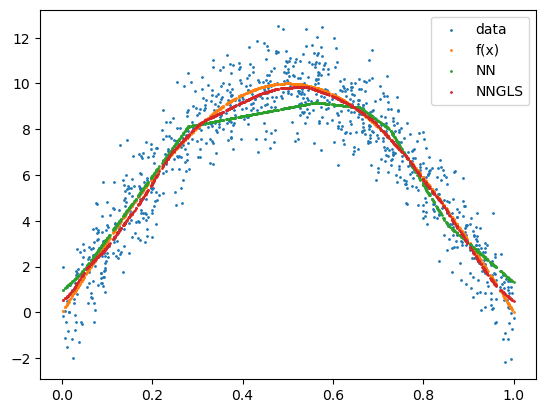

In [67]:
plt.clf()
plt.scatter(X.detach().numpy(), Y.detach().numpy(), s = 1, label = 'data')
plt.scatter(X.detach().numpy(), funXY(X.detach().numpy()), s = 1, label = 'f(x)')
plt.scatter(X.detach().numpy(), mlp_nn(X).detach().numpy(), s = 1, label = 'NN')
plt.scatter(X.detach().numpy(), mlp_nngls(X).detach().numpy(), s = 1, label = 'NNGLS')
plt.legend()
plt.show()

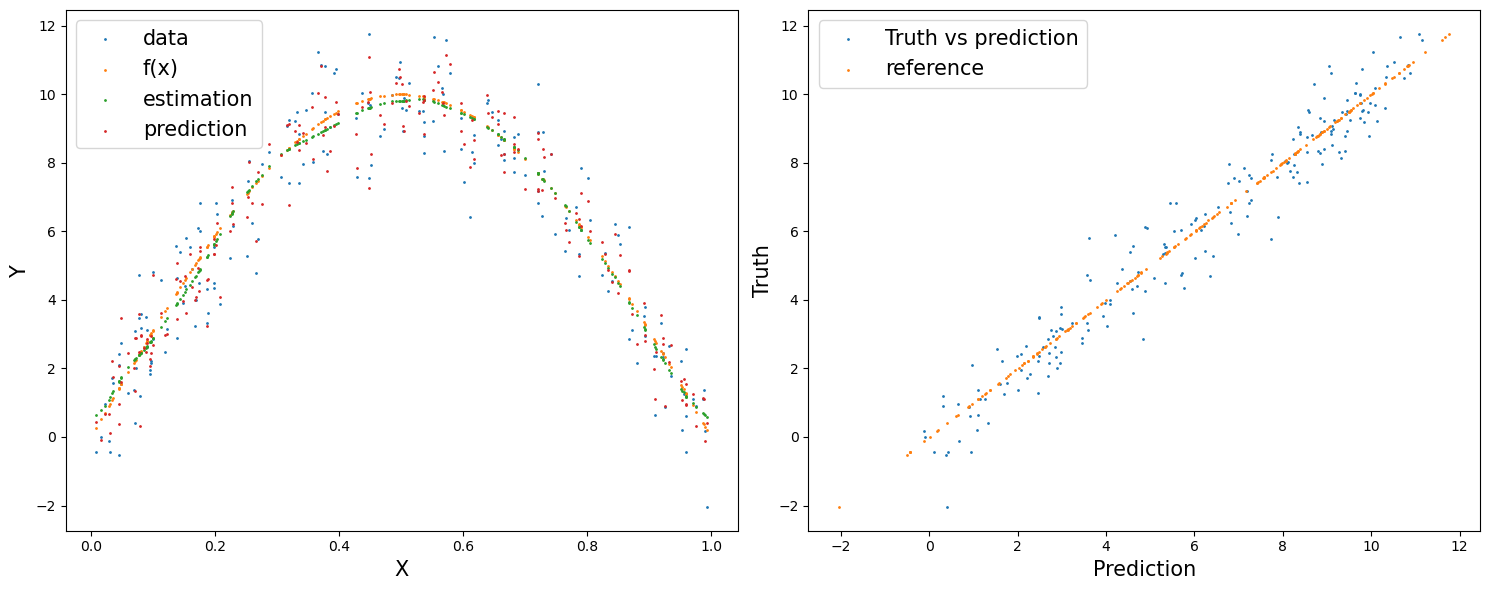

In [68]:
test_predict = model.predict(data_train, data_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(data_test.x.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'data')
axes[0].scatter(data_test.x.detach().numpy(), funXY(data_test.x.detach().numpy()), s = 1, label = 'f(x)')
axes[0].scatter(data_test.x.detach().numpy(), mlp_nngls(data_test.x).detach().numpy(), s = 1, label = 'estimation')
axes[0].scatter(data_test.x.detach().numpy(), test_predict.detach().numpy(), s = 1, label = 'prediction')
axes[0].set_xlabel('X', fontsize=15)
axes[0].set_ylabel('Y', fontsize=15)
axes[0].legend(prop={'size': 15})

axes[1].scatter(test_predict.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'Truth vs prediction')
axes[1].scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s = 1, label = 'reference')
axes[1].set_xlabel("Prediction", fontsize=15)
axes[1].set_ylabel("Truth", fontsize=15)
axes[1].legend(prop={'size': 15})
plt.tight_layout()

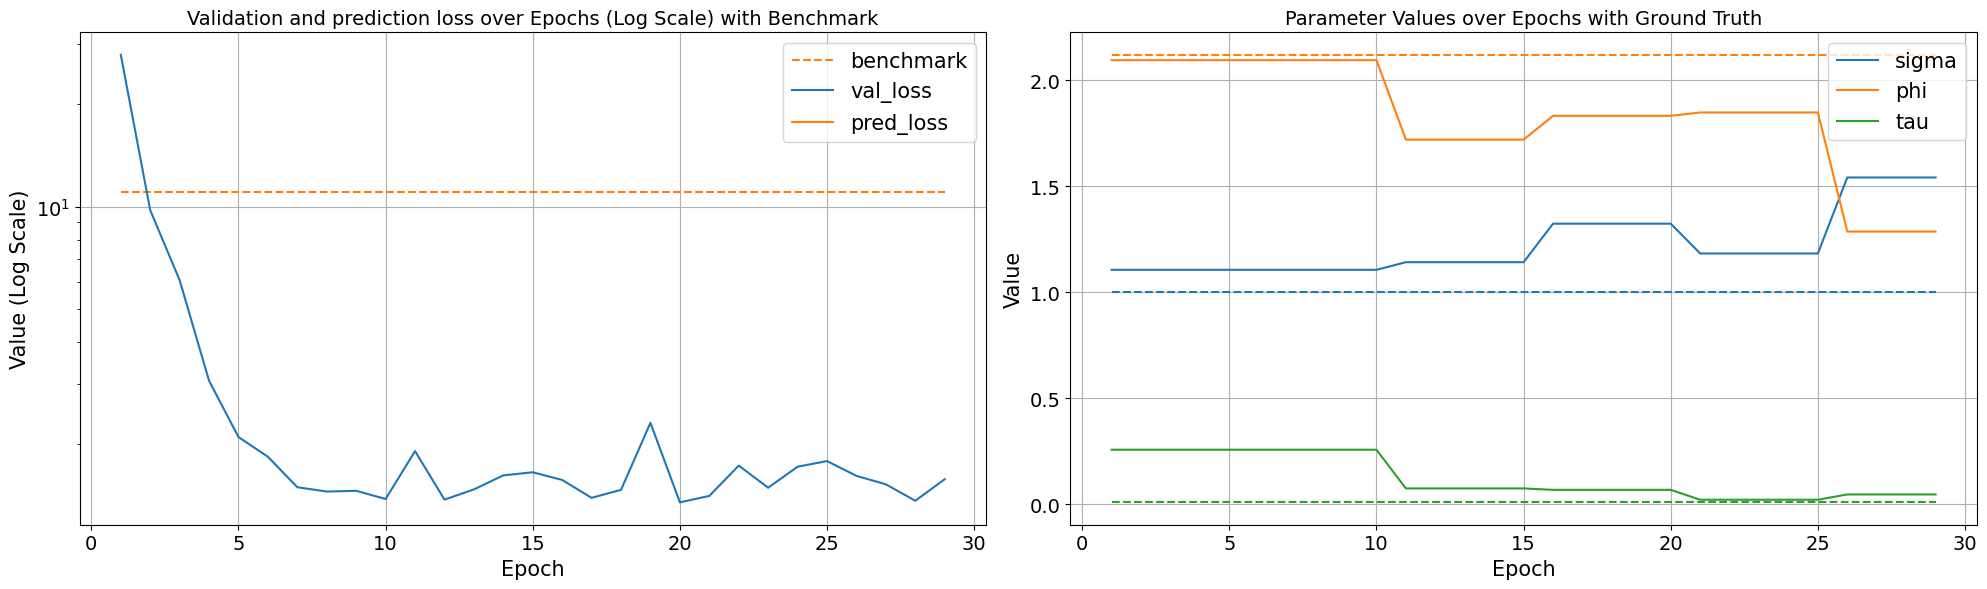

In [69]:
epoch = len(training_log["val_loss"])
training_log["epoch"] = list(range(1, epoch + 1))
training_log["pred_loss"] = None
training_log = pd.DataFrame(training_log)

# Melting the dataframe to make it suitable for seaborn plotting
training_log_melted = training_log[["epoch", "val_loss", "pred_loss"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')

# Finding the color used for the 'metric' in the plot
palette = sns.color_palette()
metric_color = palette[1]  # Assuming 'metric' is the second line in the plot

# Plotting with seaborn
# Creating two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
benchmark_line = axes[0].hlines(y=benchmark_mse, xmin=1, xmax=epoch, color=metric_color, linestyle='--', label='benchmark')
sns.lineplot(ax=axes[0], data=training_log_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)

axes[0].set_title('Validation and prediction loss over Epochs (Log Scale) with Benchmark', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Value (Log Scale)', fontsize=15)
axes[0].set_yscale('log')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(labelsize=14)
axes[0].grid(True)

# Second plot (sigma, phi, tau)
kernel_params_melted = training_log[["epoch", "sigma", "phi", "tau"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')
ground_truth = {'sigma': sigma, 'phi': phi/np.sqrt(2), 'tau': tau}
sns.lineplot(ax=axes[1], data=kernel_params_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)
palette = sns.color_palette()
for i, (param, gt_value) in enumerate(ground_truth.items()):
    axes[1].hlines(y=gt_value, xmin=1, xmax=epoch, color=palette[i], linestyle='--')
axes[1].set_title('Parameter Values over Epochs with Ground Truth', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('Value', fontsize=15)
axes[1].legend(prop={'size': 15})
axes[1].tick_params(labelsize=14)
axes[1].grid(True)

plt.tight_layout()

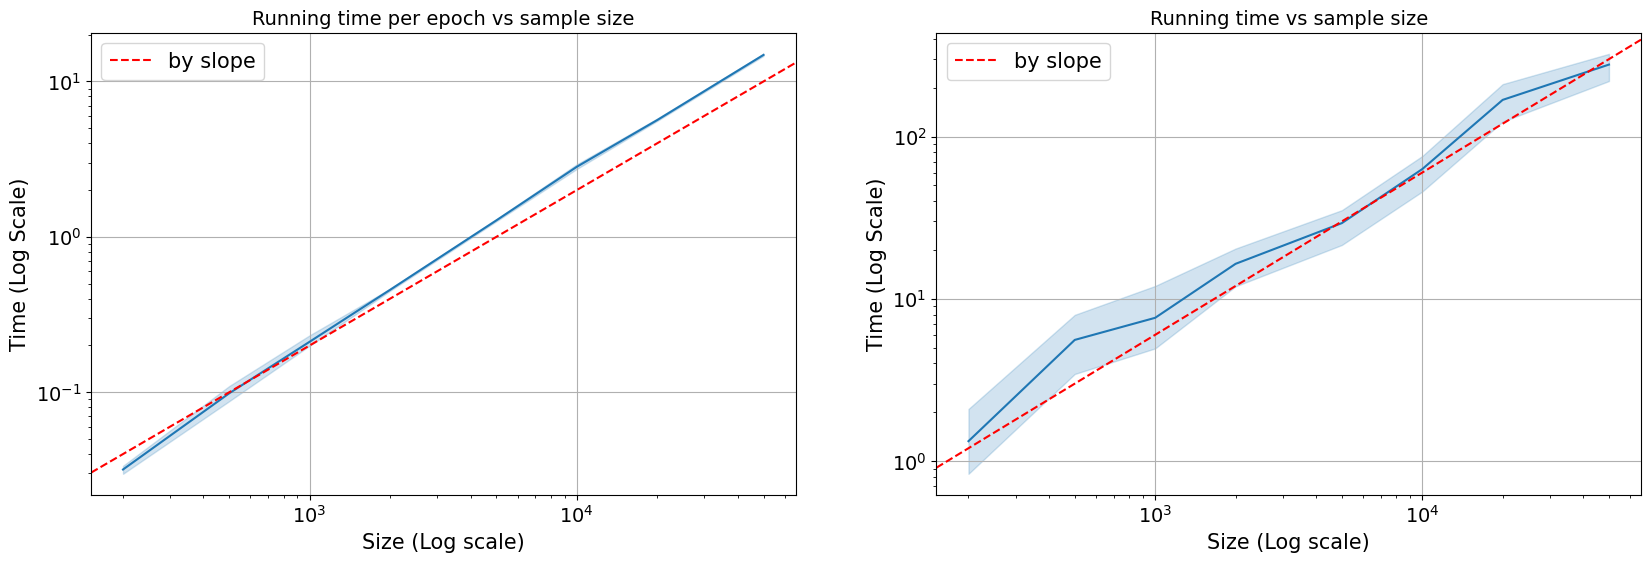

In [18]:
time_df = pd.read_csv("./data/running_time.csv")
time_df['Time per epoch'] = time_df['time']/time_df['epoch']

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.lineplot(ax=axes[0], data=time, x='size', y='Time per epoch', markers=False, dashes=False)
axes[0].set_title('Running time per epoch vs sample size', fontsize=14)
axes[0].axline((200, 0.04), slope=1, color='red', label='by slope', linestyle='--')
axes[0].set_xlabel('Size (Log scale)', fontsize=15)
axes[0].set_ylabel('Time (Log Scale)', fontsize=15)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(labelsize=14)
axes[0].grid(True)

sns.lineplot(ax=axes[1], data=time, x='size', y='time', markers=False, dashes=False)
axes[1].set_title('Running time vs sample size', fontsize=14)
axes[1].axline((200, 1.2), slope=1, color='red', label='by slope', linestyle='--')
axes[1].set_xlabel('Size (Log scale)', fontsize=15)
axes[1].set_ylabel('Time (Log Scale)', fontsize=15)
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].legend(prop={'size': 15})
axes[1].tick_params(labelsize=14)
axes[1].grid(True)
#axes[1].set_yscale('log')